In [12]:
import wec_as_multiport as wam
import wecopttool as wot
import capytaine as cpy
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, NullFormatter
import pandas as pd

gfx_path = os.path.join('..','gfx')
base_name = 'wec_as_multiport_'

In [2]:
f1 = 0.025
nfreq = 60
freq = wot.frequency(f1, nfreq, False)  # False -> no zero frequency

wb = wot.geom.WaveBot()  # use standard dimensions
mesh_size_factor = 0.5  # 1.0 for default, smaller to refine mesh
mesh = wb.mesh(mesh_size_factor)
fb = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
fb.add_translation_dof(name="Heave")

In [3]:
bem_data_fname = 'wec_as_multiport.nc'

if os.path.isfile(bem_data_fname):
    bem_data = wot.read_netcdf(bem_data_fname)
else:
    bem_data = wot.run_bem(fb, freq)
    bem_data = bem_data.assign_coords(
        freq=("omega", bem_data['omega'].values/2/np.pi))
    bem_data['freq'].attrs['long_name'] = 'Frequency'
    bem_data['freq'].attrs['units'] = 'Hz'
    bem_data = wot.add_linear_friction(bem_data)
    wot.write_netcdf(bem_data_fname, bem_data)

In [4]:
wec = wam.WEC(omega=bem_data['omega'].values,
            N=12.4666,
            Kt=6.1745,
            Rw=0.5,
            Lw=0,
            Jd=2,
            Bd=1,
            Kd=0,
            Zi=np.squeeze(wot.hydrodynamic_impedance(bem_data)).values,
            Hexc=np.squeeze(bem_data['excitation_force'].values))

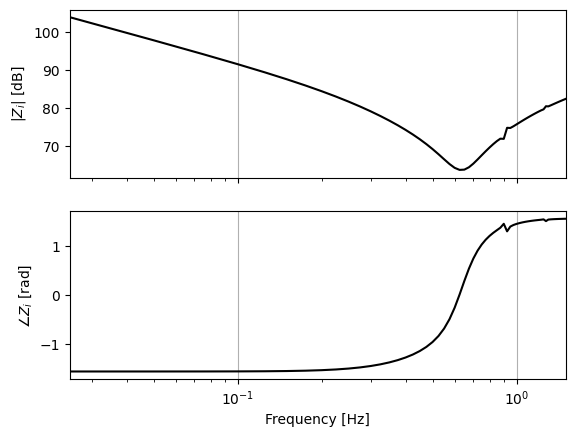

In [5]:
fig, ax = plt.subplots(nrows=2,
                       sharex=True)

ax[0].plot(wec.freq, 20*np.log10(np.abs(wec.Zi)), color='k')
ax[0].set_ylabel('$|Z_i|$ [dB]')

ax[1].plot(wec.freq, np.angle(wec.Zi), color='k')
ax[1].set_ylabel('$\\angle{Z_i}$ [rad]')

ax[-1].set_xlabel('Frequency [Hz]')

for axi in ax:
    axi.set_xscale('log')
    axi.autoscale(enable=True, axis='x', tight=True)
    axi.grid(which='major', axis='x')
    axi.set_title('')
    axi.label_outer()

Text(0.5, 0, 'Frequency [Hz]')

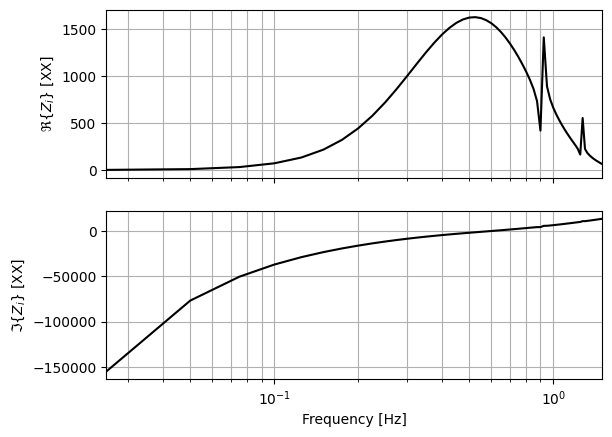

In [6]:
fig, ax = plt.subplots(nrows=2,
                       sharex=True)

ax[0].plot(wec.freq, np.real(wec.Zi), color='k')
ax[0].set_ylabel('$\\Re\{Z_i\}$ [XX]')

ax[1].plot(wec.freq, np.imag(wec.Zi), color='k')
ax[1].set_ylabel('$\\Im\{Z_i\}$ [XX]')

for axi in ax:
    axi.set_xscale('log')
    axi.autoscale(enable=True, axis='x', tight=True)
    axi.grid(which='both', axis='both')
    axi.set_title('')
    axi.label_outer()
    
ax[-1].set_xlabel('Frequency [Hz]')

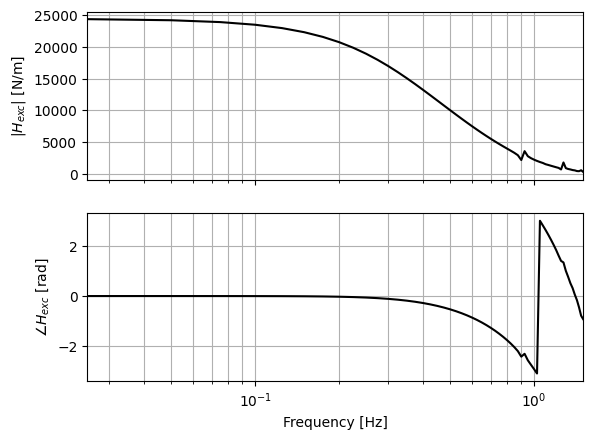

In [7]:
fig, ax = plt.subplots(nrows=2, sharex=True)

ax[0].plot(wec.freq, np.abs(wec.Hexc), color='k')
ax[1].plot(wec.freq, np.angle(wec.Hexc), color='k')

ax[0].set_ylabel('$| H_{exc} | $ [N/m]')
ax[1].set_ylabel('$\\angle{H_{exc}}$ [rad]')
ax[-1].set_xlabel('Frequency [Hz]')

for axi in ax:
    axi.set_xscale('log')
    axi.autoscale(enable=True, axis='x', tight=True)
    axi.grid(which='both', axis='both')
    axi.set_title('')
    axi.label_outer()

# Contoller design

## Controller impedances

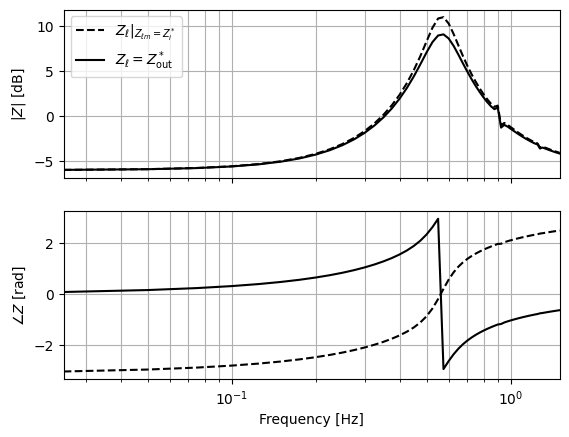

In [17]:
fig, ax = plt.subplots(nrows=2,
                       sharex=True)

ax[0].plot(wec.freq, 20*np.log10(np.abs(wec.Zl_opt_mech)),
           color='k', 
           ls='--', 
           label='$Z_\ell \\vert_{Z_{\ell m} = Z_i^*}$')
ax[0].plot(wec.freq, 20*np.log10(np.abs(wec.Zl_opt)),
           color='k', 
           ls='-',
           label='$Z_\ell = Z_{\\mathrm{out}}^*$')

ax[1].plot(wec.freq, np.angle(wec.Zl_opt_mech),
           color='k', 
           ls='--', 
           label='$Z_\ell \\vert_{Z_{\ell m} = Z_i^*}$')
ax[1].plot(wec.freq, np.angle(wec.Zl_opt),
           color='k', 
           ls='-',
           label='$Z_\ell = Z_{\\mathrm{out}}^*$')

for axi in ax:
    axi.set_xscale('log')
    axi.autoscale(enable=True, axis='x', tight=True)
    axi.grid(which='both', axis='both')
    axi.set_title('')
    axi.label_outer()
    
ax[0].legend()
ax[-1].set_xlabel('Frequency [Hz]')

ax[0].set_ylabel('$|Z|$ [dB]')
ax[1].set_ylabel('$\\angle{Z}$ [rad]')

fig.savefig(os.path.join(gfx_path,base_name + 'load_impedance_for_mech_power.pdf'))

## Power output

In [9]:
# wot.waves.jonswap_spectrum(freq=wec.freq, fp=0.4, hs=1, gamma=1)
# wot.waves.long_crested_wave()

fp_list = [0.4, 0.5, 0.6]
pow_list = []

for fp in fp_list:
    efth = wot.waves.omnidirectional_spectrum(wec.f1, 
                                            wec.nfreq, 
                                            lambda f: wot.waves.pierson_moskowitz_spectrum(f, fp, 0.2), 
                                            "Pierson-Moskowitz")
    waves = wot.waves.long_crested_wave(efth, 1)
    Fexc = wec.Fexc(waves=waves.squeeze().values)
    pow = np.sum(wec.active_power(Fexc=Fexc, Zl=wec.Zl_opt))
    pow_list.append(pow)
    # print(pow)
    
df = pd.DataFrame(pow_list, fp_list, 
                  columns=['Elec. power [W]'])
print(df.transpose().to_latex(float_format='%.1f'))

\begin{tabular}{lrrr}
\toprule
 & 0.400000 & 0.500000 & 0.600000 \\
\midrule
Elec. power [W] & 184.5 & 49.0 & -13.0 \\
\bottomrule
\end{tabular}



# Compare different drive trains

## Kd

Text(0.5, 0.02, 'Frequency [Hz]')

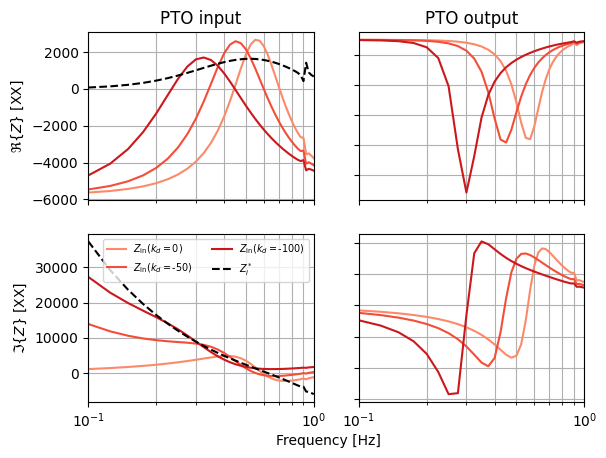

In [10]:
Kd_list = [0, -50, -100]

wec_compare_Kd = []

for Kd in Kd_list:
    wec_tmp = wec.copy()
    wec_tmp.Kd = Kd
    wec_compare_Kd.append(wec_tmp)

fig, ax = plt.subplots(nrows=2,
                       ncols=2,
                       sharex=True)

colors = plt.cm.Reds(np.linspace(0.4, 0.75, len(wec_compare_Kd)))
mask = (wec.freq >= 0.1) & (wec.freq <= 1)

for wec1, color in zip(wec_compare_Kd, colors):
    ax[0,0].plot(wec1.freq[mask], np.real(wec1.Zin()[mask]),
               color=color,
               label='$Z_{\mathrm{in}}(k_d=$' + f'{wec1.Kd})')
    ax[1,0].plot(wec1.freq[mask], np.imag(wec1.Zin()[mask]),
               color=color,
               label='$Z_{\mathrm{in}}(k_d=$' + f'{wec1.Kd})')
    
    ax[0,1].plot(wec1.freq[mask], np.real(wec1.Zout[mask]),
               color=color,
               label='$Z_{\mathrm{in}}(k_d=$' + f'{wec1.Kd})')
    ax[1,1].plot(wec1.freq[mask], np.imag(wec1.Zout[mask]),
               color=color,
               label='$Z_{\mathrm{in}}(k_d=$' + f'{wec1.Kd})')
    

ax[0,0].plot(wec.freq[mask], np.real(np.conj(wec.Zi[mask])),
           color='k',
           ls='--',
           label='$Z_i^*$')
ax[1,0].plot(wec.freq[mask], np.imag(np.conj(wec.Zi[mask])),
           color='k',
           ls='--',
           label='$Z_i^*$')

for axi in ax.flatten():
    axi.set_xscale('log')
    axi.autoscale(enable=True, axis='x', tight=True)
    axi.grid(which='both', axis='both')
    axi.set_title('')
    axi.label_outer()
    # axi.xaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
    axi.xaxis.set_minor_formatter(NullFormatter())

ax[0,0].set_ylabel('$\\Re\{Z\}$ [XX]')
ax[1,0].set_ylabel('$\\Im\{Z\}$ [XX]')

ax[1,0].legend(ncol=2, fontsize='x-small')
# ax[-1].set_xlabel('Frequency [Hz]')

ax[0][0].set_title('PTO input')
ax[0][1].set_title('PTO output')
fig.text(0.5, 0.02, 'Frequency [Hz]', ha='center')

## Jd

Text(0.5, 0.02, 'Frequency [Hz]')

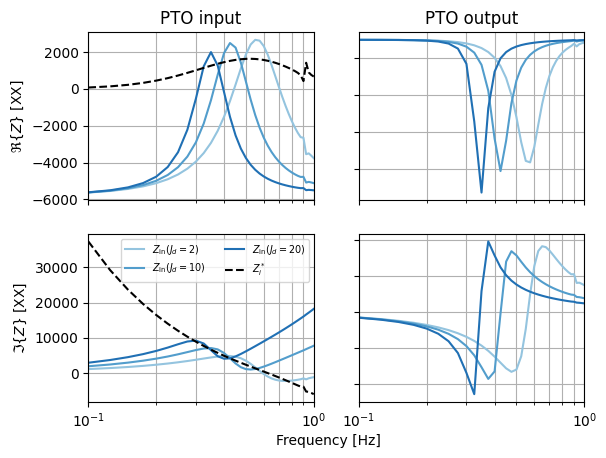

In [11]:
Jd_list = [2, 10, 20]

wec_compare_Jd = []

for Jd in Jd_list:
    wec_tmp = wec.copy()
    wec_tmp.Jd = Jd
    wec_compare_Jd.append(wec_tmp)

fig, ax = plt.subplots(nrows=2,
                       ncols=2,
                       sharex=True)

colors = plt.cm.Blues(np.linspace(0.4, 0.75, len(wec_compare_Jd)))
mask = (wec.freq >= 0.1) & (wec.freq <= 1)

for wec1, color in zip(wec_compare_Jd, colors):
    ax[0,0].plot(wec1.freq[mask], np.real(wec1.Zin()[mask]),
               color=color,
               label='$Z_{\mathrm{in}}(J_d=$' + f'{wec1.Jd})')
    ax[1,0].plot(wec1.freq[mask], np.imag(wec1.Zin()[mask]),
               color=color,
               label='$Z_{\mathrm{in}}(J_d=$' + f'{wec1.Jd})')
    
    ax[0,1].plot(wec1.freq[mask], np.real(wec1.Zout[mask]),
               color=color,
               label='$Z_{\mathrm{in}}(J_d=$' + f'{wec1.Jd})')
    ax[1,1].plot(wec1.freq[mask], np.imag(wec1.Zout[mask]),
               color=color,
               label='$Z_{\mathrm{in}}(J_d=$' + f'{wec1.Jd})')
    

ax[0,0].plot(wec.freq[mask], np.real(np.conj(wec.Zi[mask])),
           color='k',
           ls='--',
           label='$Z_i^*$')
ax[1,0].plot(wec.freq[mask], np.imag(np.conj(wec.Zi[mask])),
           color='k',
           ls='--',
           label='$Z_i^*$')

for axi in ax.flatten():
    axi.set_xscale('log')
    axi.autoscale(enable=True, axis='x', tight=True)
    axi.grid(which='both', axis='both')
    axi.set_title('')
    axi.label_outer()
    # axi.xaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))
    axi.xaxis.set_minor_formatter(NullFormatter())

ax[0,0].set_ylabel('$\\Re\{Z\}$ [XX]')
ax[1,0].set_ylabel('$\\Im\{Z\}$ [XX]')

ax[1,0].legend(ncol=2, fontsize='x-small')
# ax[-1].set_xlabel('Frequency [Hz]')

ax[0][0].set_title('PTO input')
ax[0][1].set_title('PTO output')
fig.text(0.5, 0.02, 'Frequency [Hz]', ha='center')